# Data Exploration for a Machine Learning Stock Predictor

In [1]:
# import needed libraries
import os
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions
---

Global functions intended to make computations easier. These are also developed with the intention to be used in the final code implimentaion

In [2]:

################################################
# Data Gathering Helpers
################################################
def path_to_data(ticker, base_dir='data'):
    return os.path.join(base_dir, '{}.csv'.format(ticker))

def fetch_data(ticker_list, dates):
    df = pd.DataFrame(index=dates)
    
    if 'SPY' not in ticker_list:
        ticker_list.insert(0, 'SPY')
        
    for ticker in range(0, len(ticker_list)):
        df_temp = pd.read_csv(
            path_to_data(ticker_list[ticker]), 
            usecols=['Date', 'Adj Close'], 
            index_col='Date', 
            parse_dates=True, 
            na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close' : ticker_list[ticker]})
        df = df.join(df_temp)
    
    df = df.dropna(subset=['SPY'])
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

################################################
# STATS Helpers
################################################
def normalize_data(df):
    return df/df.iloc[0,:]

def print_stats(df):
    print 'Global Mean:'
    print df.mean()
    print '\nGlobal Median:'
    print df.median()
    print '\nGlobal Std:'
    print df.std()

def get_daily_returns(df):
    daily_returns = df.copy()
    daily_returns[1:] = (daily_returns[1:] / daily_returns[0:-1].values) - 1
    daily_returns.iloc[0, : ] = 0
    return daily_returns

# rolling stats
def get_rolling_mean(vals, window=20):
    return vals.rolling(window,center=False).mean()

def get_rolling_std(vals, window=20):
    return vals.rolling(window,center=False).std()

def get_bollinger_bands(rolling_mean, rolling_std):
    lower_band = rolling_mean - (rolling_std * 2)
    upper_band = rolling_mean + (rolling_std * 2)
    return lower_band, upper_band

def get_bollinger_ratios(series, sma, r_std, window=20):
    bb = series.copy()
    bb[window:] = (bb[window:] - sma[window:]) / (2 * r_std[window:])
    return bb[window:]

def get_momentum(df, window=20):
    momentum = df.copy()
    momentum[window:] = (momentum[window:] / momentum[0:-window].values) - 1
    return momentum[window:]

def get_sma_ratio(df, window=20):
    sma = df.copy()
    sma[window:] = (sma[window:] / sma[0:-window].mean()) - 1
    return sma[window:]

def normalize_feature(series):
    return (series - series.mean())/series.std()

################################################
# Graph Plotting Helpers
################################################
def plot_hist_with_stats(df, bins=10, title=''):
    
    mean = df.mean()
    std = df.std()
    
    df.hist(bins=bins)
    plt.axvline(mean, color='w', linestyle='dashed', linewidth=2)
    plt.axvline(mean + std, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(mean - std, color='r', linestyle='dashed', linewidth=2)
    plt.show()

def plot_hist_multi(df, bins=10, title=''):
    for stock in df:
        df[stock].hist(bins=bins, label=stock, alpha = 0.5)
    plt.legend(loc='best')
    plt.show()
    
def print_bollinger_bands(series, rolling_mean, lower_band, upper_band, label=''):
    val = ax = series.plot(title='Bollinger Bands: ' + label, label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    ub = upper_band.plot(label='Upper Band', ax=ax)
    lb = lower_band.plot(label='Lower Band', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    plt.show()
    
def plot_momentum(series, rolling_mean, label=''):
    val = ax = series.plot(title='Momentum: ' + label, label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    plt.show()
    
def plot_data(df, title='Stock Prices', xlabel='Date', ylabel='Price'):
    ax = df.plot(title=title, fontsize=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    
def plot_predictions(true_vals, pred_vals, x_label='Actual', y_label='CLF Predictions'):
    fig, ax = plt.subplots()
    ax.scatter(actual_vals, pred_vals)
    ax.plot([pred_vals.min(), pred_vals.max()], [pred_vals.min(), pred_vals.max()], 'k--', lw=4)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()

## Process Data for Selected Stocks
---

In [3]:
# use two years of dates for data exploration
dates = pd.date_range('2015-07-14', '2017-07-14')

ticker = 'NVDA'
metrics_window = 10

# These will be the tickers we will be working with to build our model
# SPY is added as a benchmark model. 
tickers = [ticker]


df_explore = fetch_data(tickers, dates)
print df_explore.head(n=5)

                   SPY       NVDA
2015-07-14  210.679993  19.889999
2015-07-15  210.610001  19.750000
2015-07-16  212.300003  20.190001
2015-07-17  212.479996  20.070000
2015-07-20  212.589996  19.700001


## Visualize the Data of the Selected Stocks
---


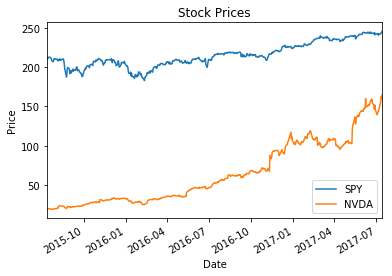

In [4]:
plot_data(df_explore)

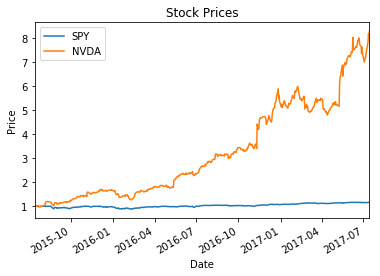

In [5]:
normalized_data = normalize_data(df_explore)
plot_data(normalized_data)

## Global Stats
---

Global stats of the stocks we are interested in

---

In [6]:
print_stats(df_explore)

Global Mean:
SPY     215.291976
NVDA     64.573142
dtype: float64

Global Median:
SPY     212.509995
NVDA     52.789999
dtype: float64

Global Std:
SPY     15.365571
NVDA    39.429432
dtype: float64


## Rolling Stats
---


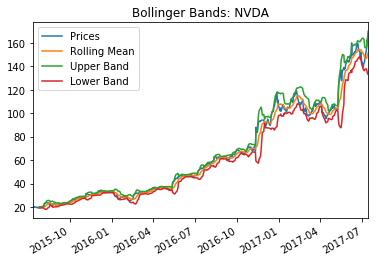

In [7]:
rolling_mean = get_rolling_mean(df_explore[ticker], metrics_window)
rolling_std = get_rolling_std(df_explore[ticker], metrics_window)
lower_band, upper_band = get_bollinger_bands(rolling_mean, rolling_std)

print_bollinger_bands(df_explore[ticker], rolling_mean, lower_band, upper_band, ticker)

## Daily Returns
---

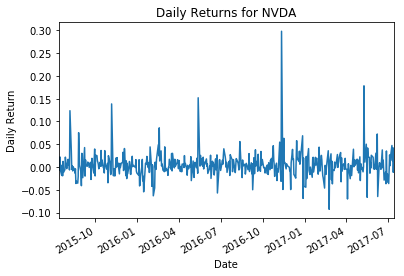

Max/Min Daily Returns for NVDA
Max: 0.298067063512
Min: -0.0927230391347


In [8]:
daily_returns  = get_daily_returns(df_explore)
plot_data(daily_returns[ticker], title='Daily Returns for ' + ticker, xlabel='Date', ylabel='Daily Return')

print 'Max/Min Daily Returns for ' + ticker
print 'Max:', daily_returns[ticker].max()
print 'Min:', daily_returns[ticker].min()

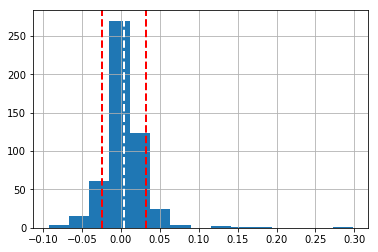

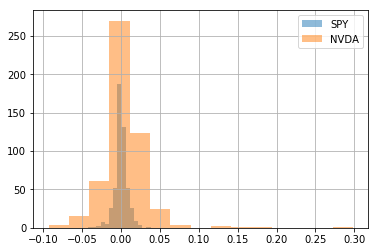

In [9]:
plot_hist_with_stats(daily_returns[ticker], bins=15, title=ticker)
plot_hist_multi(daily_returns, bins=15)

## Momentum
---

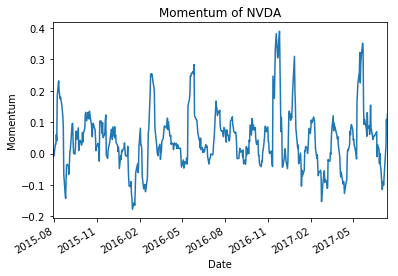

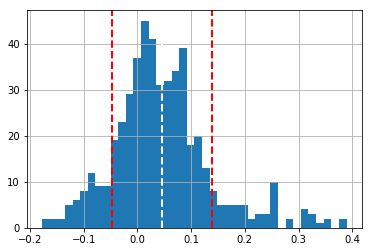

Max/Min Momentum for NVDA
Max: 0.389405462125
Min: -0.177487808783


In [10]:
momentum = get_momentum(df_explore[ticker], window=metrics_window)

plot_data(momentum, title='Momentum of ' + ticker, xlabel='Date', ylabel='Momentum')
plot_hist_with_stats(momentum, bins=40, title=ticker)

print 'Max/Min Momentum for ' + ticker
print 'Max:', momentum.max()
print 'Min:', momentum.min()

## Simple Moving Average Ratio
---

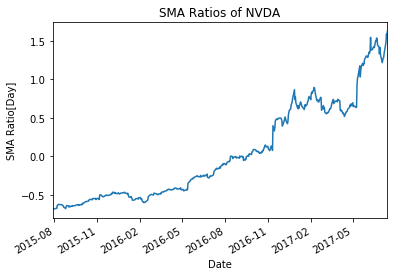

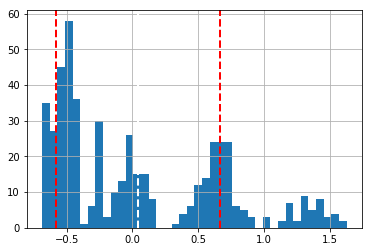

Max/Min SMA Ratio for NVDA
Max:  1.62571900665
Min:  -0.685932482913


In [11]:
sma_ratios = get_sma_ratio(df_explore[ticker], window=metrics_window)

plot_data(sma_ratios, title='SMA Ratios of NVDA', xlabel='Date', ylabel='SMA Ratio[Day]')
plot_hist_with_stats(sma_ratios, bins=40, title=ticker)

print 'Max/Min SMA Ratio for ' + ticker
print 'Max: ', sma_ratios.max()
print 'Min: ', sma_ratios.min()

## Bolinger Ratios
---

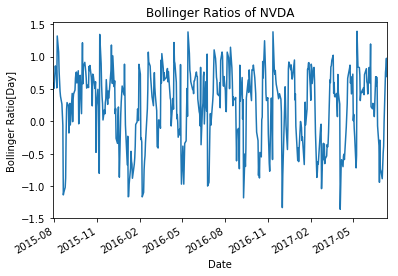

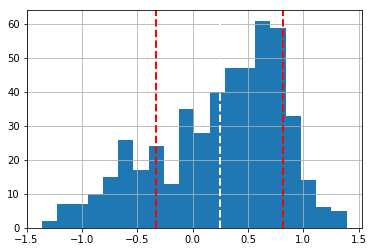

Max/Min BB Ratio for NVDA
Max: 1.39056077428
Min: -1.35869858244


In [12]:
bb_ratios = get_bollinger_ratios(series=df_explore[ticker], sma=rolling_mean, r_std=rolling_std, window=metrics_window)

plot_data(bb_ratios, title='Bollinger Ratios of ' + ticker, xlabel='Date', ylabel='Bollinger Ratio[Day]')
plot_hist_with_stats(bb_ratios, bins=20, title=ticker)

print 'Max/Min BB Ratio for ' + ticker
print 'Max:', bb_ratios.max()
print 'Min:', bb_ratios.min()

## Set Up the Feature Set
---


In [13]:
# recombine the features into a new Data Frame X and Y. 
# X will be a frame of all the featres for and Y will be the outcomes

d = { 'BB_RATIOS' : bb_ratios, 'SMA_RATIOS' : sma_ratios, 'MOMENTUM' : momentum }
features_df = pd.DataFrame(d)

X_features = features_df[0 : -1].values
y_target = df_explore[ticker][(metrics_window + 1) : ].values

X_faetures_7152017 = features_df.tail(1)

print 'Features Length', len(X_features)
print 'Target Length', len(y_target)


Features Length 495
Target Length 495


## KNN
---


Train scores [1.0, 1.0, 1.0]
Train Scores Mean 1.0, Train Scores STD 0.0

Test scores [-0.520432398707948, -1.8633802820961349, -0.49238335920927945]
Test Scores Mean -0.958732013338, Test Scores STD 0.639785409222

Predictions [ 103.0447412    98.02578497  102.78822739   98.96791568   96.71331608
   99.25947728  101.88215811  103.90600754   99.79825646   99.95471238
  105.94952871  106.02499425]

Actual [ 105.160004  104.010002  105.089996  107.330002  107.790001  109.650002
  111.769997  110.019997  109.18      113.949997  115.389999  114.379997]


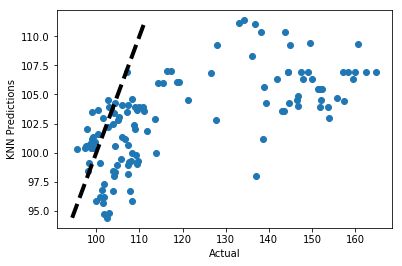

In [14]:
pipe_knn = Pipeline([
        ('scl', StandardScaler()),
        ('clf', KNeighborsRegressor(n_neighbors=5, weights='distance'))
    ])

tscv = TimeSeriesSplit(n_splits=3)
train_scores = []
test_scores = []

final_predics = []
actual_vals = []

for train_index, test_index in tscv.split(X_features):
    pipe_knn.fit(X_features[train_index], y_target[train_index])
    
    train_score = pipe_knn.score(X_features[train_index], y_target[train_index])
    test_score = pipe_knn.score(X_features[test_index], y_target[test_index])
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    final_predic = pipe_knn.predict(X_features[test_index])
    actual_vals = y_target[test_index]

print '\nTrain scores', train_scores
print 'Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std())

print '\nTest scores', test_scores
print 'Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std())

print '\nPredictions', final_predic[0: 12]

print '\nActual', actual_vals[0: 12]

plot_predictions(actual_vals, final_predic, y_label='KNN Predictions')

## Linear Regression 
---


Train scores [0.97612664967981166, 0.99217583966585587, 0.99519416542680761]
Train Scores Mean 0.987832218257, Train Scores STD 0.00836830625614

Test scores [0.98486958799777902, 0.97661017384105897, 0.97194658312438165]
Test Scores Mean 0.977808781654, Test Scores STD 0.00534343892121

Predictions [ 103.46985738  105.61210732  104.4990622   105.55007289  107.72155195
  108.17624879  110.01185235  112.1165844   110.42505462  109.60029508
  114.29256218  115.7510993 ]

Actual [ 105.160004  104.010002  105.089996  107.330002  107.790001  109.650002
  111.769997  110.019997  109.18      113.949997  115.389999  114.379997]

Adjusted value first day after Selected Dates
[ 165.4873633]


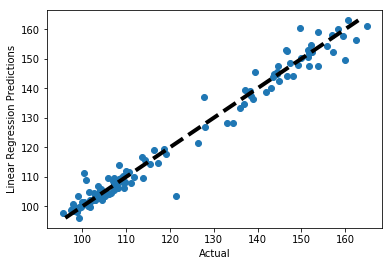

In [15]:

pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('clf', LinearRegression())
    ])

tscv = TimeSeriesSplit(n_splits=3)
train_scores = []
test_scores = []

final_predics = []
actual_vals = []

for train_index, test_index in tscv.split(X_features):
    pipe_lr.fit(X_features[train_index], y_target[train_index])
    
    train_score = pipe_lr.score(X_features[train_index], y_target[train_index])
    test_score = pipe_lr.score(X_features[test_index], y_target[test_index])
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    final_predic = pipe_lr.predict(X_features[test_index])
    actual_vals = y_target[test_index]

print '\nTrain scores', train_scores
print 'Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std())

print '\nTest scores', test_scores
print 'Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std())

print '\nPredictions', final_predic[0: 12]

print '\nActual', actual_vals[0: 12]

X_faetures_7152017 = pipe_lr.predict(features_df.tail(1))
print '\nAdjusted value first day after Selected Dates\n', X_faetures_7152017

plot_predictions(actual_vals, final_predic, y_label='Linear Regression Predictions')

## Random Forests


Train scores [0.99176066956877973, 0.99800409814950142, 0.99852924596101245]
Train Scores Mean 0.99609800456, Train Scores STD 0.00307444316628

Test scores [-0.5023387202023839, -1.8403808440155192, -0.37059159670067082]
Test Scores Mean -0.90443705364, Test Scores STD 0.663994181799

Predictions [ 104.2339998  105.814      103.7959994  104.8679994  105.7060014
  104.7600008  106.728      106.728      106.8559998  107.464      106.728
  106.728    ]

Actual [ 105.160004  104.010002  105.089996  107.330002  107.790001  109.650002
  111.769997  110.019997  109.18      113.949997  115.389999  114.379997]


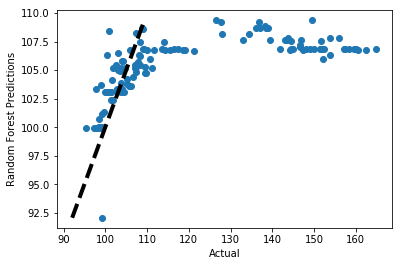

In [16]:
clf_rf = RandomForestRegressor(n_estimators=5)
tscv = TimeSeriesSplit(n_splits=3)

train_scores = []
test_scores = []

final_predics = []
actual_vals = []

for train_index, test_index in tscv.split(X_features):
    clf_rf.fit(X_features[train_index], y_target[train_index])
    
    train_score = clf_rf.score(X_features[train_index], y_target[train_index])
    test_score = clf_rf.score(X_features[test_index], y_target[test_index])
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    final_predic = clf_rf.predict(X_features[test_index])
    actual_vals = y_target[test_index]

print '\nTrain scores', train_scores
print 'Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std())

print '\nTest scores', test_scores
print 'Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std())

print '\nPredictions', final_predic[0: 12]

print '\nActual', actual_vals[0: 12]

plot_predictions(actual_vals, final_predic, y_label='Random Forest Predictions')


## Evaluation
---
After running my predictions through 3 different classifers the only one worth looking forward on is the Linear Regresion classifier.

The scores are more than acceptable, and based on the score on the training and testing set it does not seem to be overfitting.

Running through a few different stocks indicates that the more volitile the stock the worse the predictions are.

My goal now is to write some classes and functions that will be usefull in the final presentation. 

## Begin Evaluation from API
---

In the following section we will be rewriting the helper functions into classes to use in the final UI as well as connecting to Yahoo api as that will be what is used in the final UI. It will also give us the opportunity to compare how well the classifier works against our static files with the API.

In [184]:
from pandas_datareader import data, wb
import datetime
from dateutil.relativedelta import relativedelta

class Stock_Time_Series:
    def __init__(self, to_date=datetime.datetime.now(), year_span=2):
        start_date = to_date - relativedelta(years=year_span)
        self.dates = pd.date_range(start_date, to_date)
                
    def fetch_data(self, symbol_list):
        self.df = pd.DataFrame(index=self.dates)
        good_symbols = []
        bad_symbols = []
        
        if 'SPY' not in symbol_list:
            symbol_list.insert(0, 'SPY')

        for symbol in symbol_list:
            try:
                fetched_data = data.DataReader(symbol, 'yahoo', self.dates[0], self.dates[-1])
                fetched_data = fetched_data.rename(columns={'Adj Close' : symbol})
                self.df[symbol] = fetched_data[symbol]
                good_symbols.append(symbol)
            except Exception:
                bad_symbols.append(symbol)

        self.df = self.df.dropna(subset=['SPY'])
        self.df.fillna(method='ffill', inplace=True)
        self.df.fillna(method='bfill', inplace=True)
        return self.df, good_symbols, bad_symbols

In [197]:
# this will be our classifer interface
class Stock_Classifier:
    def __init__(self, n_splits=3):
        self.n_splits = n_splits
        self.clf = Pipeline([
            ('scl', StandardScaler()),
            ('clf', LinearRegression())
        ])
        self.cv = TimeSeriesSplit(n_splits=self.n_splits)
    
    def get_cv_splits(self, X, y):
        train_splits = []
        test_splits = []
        
        for train_index, test_index in self.cv.split(X):
            train_splits.append(train_index)
            test_splits.append(test_index)
            
        return train_splits, test_splits
            
    def train(self, X, y, split_indexes):      
        for set_index in split_indexes:
            self.clf.fit(X[set_index], y[set_index])
    
    def score(self, X, y, split_indexes):
        scores = []
        for set_index in split_indexes:
            scores.append(self.clf.score(X[set_index], y[set_index]))
        return scores
    
    def full_set_train(self, X, y):
        self.clf.fit(X, y)
        
    def query(self, X):
        return self.clf.predict(X)
    
    def get_splits(self):
        return self.n_splits


    
class Stock_Explorer:
    def __init__(self, series, symbol, rolling_window_size=10, prediction_window_size=14):
        self.symbol = symbol
        self.stock_clf = Stock_Classifier()
        self.series = series
        self.rolling_window_size = rolling_window_size
        self.prediction_window_size = prediction_window_size
    
    def get_json(self):
        final_json = {}
        
        # if set is empty send back error error
        if len(self.series) <= self.stock_clf.get_splits():
            final_json['error'] = 'Error with Data'
            return final_json
        
        # split and train
        self.__get_X_y()
        train_test_data = self.__train_and_test()
        
        # predict the new vals
        self.__predict_vals()
        
        #bb bands
        lower_bb, upper_bb = self.__get_bollinger_bands()
        
        final_json['Symbol'] = self.symbol
        final_json['BB_Ratios'] = self.X_features['BB_RATIOS'].values.tolist()
        final_json['Momentum'] = self.X_features['MOMENTUM'].values.tolist()
        final_json['SMA_Ratios'] = self.X_features['SMA_RATIOS'].values.tolist()
        final_json['SMA'] = self.__get_rolling_mean().values.tolist()
        final_json['Lower_bb'] = lower_bb.values.tolist()
        final_json['Upper_bb'] = upper_bb.values.tolist()
        final_json['Target_Vals'] = self.y_target.values.tolist()
        
        final_json['Stats'] = self.__get_stats()
        final_json['Prediction_Size'] = self.prediction_window_size
        final_json['Train_Test_Data'] = train_test_data
        final_json['Dates'] = self.__dates_to_string()
        
        return final_json
    
    def __dates_to_string(self):
        dates = self.series.index.strftime('%Y-%m-%d').tolist()
        return dates[self.rolling_window_size:]
        
    def __predict_vals(self):
        pw = self.prediction_window_size
        
        for i in range(0 , pw):
            pred_val = self.stock_clf.query(self.X_features.tail(1).values)[0]
            self.__update_series(pred_val)
    
    def __update_series(self, new_val):
        new_date = self.series.index[-1] + relativedelta(days=1)
        new_target = pd.Series([new_val], index=[new_date])
        self.series = self.series.append(new_target)
        self.__get_X_y()
        
    def __get_X_y(self):
        w = self.rolling_window_size
        features_df = { 'BB_RATIOS' : self.__get_bollinger_ratios(), 
             'SMA_RATIOS' : self.__get_sma_ratio(), 
             'MOMENTUM' : self.__get_momentum()}
        features_df = pd.DataFrame(features_df)
        
        self.X_features = features_df
        self.y_target = self.series[w:]
        
    
    def __train_and_test(self):
        X = self.X_features[0 : -1].values
        y = self.y_target[1 : ].values
        
        train_splits, test_splits = self.stock_clf.get_cv_splits(X, y)
        self.stock_clf.train(X, y, train_splits)
        train_scores = self.stock_clf.score(X, y, train_splits)
        test_scores = self.stock_clf.score(X, y, test_splits)
        
        self.stock_clf.full_set_train(X, y)
        
        return {'train_mean' : np.asarray(train_scores).mean(), 'train_std' : np.asarray(train_scores).std(),
              'test_mean' : np.asarray(test_scores).mean(), 'test_std' : np.asarray(test_scores).std()}
    
    def __get_rolling_mean(self):
        w = self.rolling_window_size
        sma = self.series.rolling(w, center=False).mean()
        return sma[w:]

    def __get_rolling_std(self):
        w = self.rolling_window_size
        r_std = self.series.rolling(w, center=False).std()
        return r_std[w:]

    def __get_bollinger_bands(self):
        lower_band = self.__get_rolling_mean() - (self.__get_rolling_std() * 2)
        upper_band = self.__get_rolling_mean() + (self.__get_rolling_std() * 2)
        return lower_band, upper_band

    def __get_bollinger_ratios(self):
        bb = self.series.copy()
        sma = self.__get_rolling_mean()
        r_std = self.__get_rolling_std()
        w = self.rolling_window_size
        bb[w:] = (bb[w:] - sma) / (2 * r_std)
        return bb[w:]

    def __get_momentum(self):
        momentum = self.series.copy()
        w = self.rolling_window_size
        momentum[w:] = (momentum[w:] / momentum[0:-w].values) - 1
        return momentum[w:]

    def __get_sma_ratio(self):
        sma = self.series.copy()
        w = self.rolling_window_size
        sma[w:] = (sma[w:] / sma[0:-w].mean()) - 1
        return sma[w:]

    def __get_normalize_values(self):
        return self.series/self.series[0:1].values
    
    def __get_stats(self):
        vals = self.series.values
        return {
            'Mean' : np.mean(vals),
            'Median' : np.median(vals),
            'Std' : np.std(vals)
        }


## Impliment the interface

In [195]:
test_date = datetime.datetime(2017, 7, 14)
sts = Stock_Time_Series()

stocks_df, good_symbols, bad_symbols = sts.fetch_data(['NVDA'])

print 'Successful calls:', good_symbols
print 'Bad calls:', bad_symbols

Successful calls: ['SPY', 'NVDA']
Bad calls: []


In [199]:

test_n = Stock_Explorer(stocks_df['NVDA'], 'NVDA')

f = test_n.get_json()


for it in f:
    print '\n\n', it
    print f[it]



3


error
Error with Data
